# Pyro models

Load data and libraries

In [35]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from scipy.stats import poisson
import torch
import seaborn as sns

data = pd.read_csv(here("data/recent_donations.csv"))
data

# remove columns y_2020 to y_2023
# data = data.drop(columns=["y_2020", "y_2021", "y_2022", "y_2023"])

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


Clean the dataframe and divide it into the time series and the covariates of our model

In [ ]:
# Arrange the columns so that the years are in order
years = sorted([col for col in data.columns if col.startswith('y_')])
obs = data[years].values  # shape: [N, T]
obs = np.nan_to_num(obs, nan=0).astype(int)

# Encode gender: M=0, F=1
data['gender_code'] = (data['gender'] == 'F').astype(int)

# Normalize birth_year
birth_year_mean = data['birth_year'].mean()
birth_year_std = data['birth_year'].std()
data['birth_year_norm'] = (data['birth_year'] - birth_year_mean) / birth_year_std

years_num = np.array([int(y[2:]) for y in years])  # [2009, ..., 2023]
ages = years_num[None, :] - data['birth_year'].values[:, None]
# Normalize
ages_norm = (ages - ages.mean()) / ages.std()

# Covariates: example with birth_year_norm and gender_code, later we can add more
covariates = data[['birth_year_norm', 'gender_code']].values  # shape: [N, 2]

# Repeat covariates for all years (if fixed per individual), for example with age we should update it for each year
covariates = np.repeat(covariates[:, None, :], len(years), axis=1)  # shape: [N, T, num_covariates]

# Convert everything to torch tensors
obs_torch = torch.tensor(obs, dtype=torch.long)
covariates_torch = torch.tensor(covariates, dtype=torch.float)

# Add normalized age as a covariate
covariates = np.concatenate([covariates, ages_norm[:, :, None]], axis=2)  # shape: [N, T, 3]
covariates_torch = torch.tensor(covariates, dtype=torch.float)

## HMM without covariates

Let’s start with our models!
First of all, we will start with a Hidden Markov Model. We don’t use a classic HMM with a Gaussian as emission probabilities but a categorical (discrete) emission distribution, where each hidden state emits observable symbols according to its own categorical probability vector.

For inference, we use Stochastic Variational Inference (SVI), which allows us to approximate the posterior distributions of the model parameters efficiently. The optimization is performed using the Adam optimizer, an adaptive learning rate method that helps the model converge quickly and stably during training.

In [38]:
from pyro.infer import SVI, TraceEnum_ELBO  

num_states = 3  # Number of hidden states
num_obs = int(obs_torch.max().item()) + 1

pyro.clear_param_store()  # resetta tutti i parametri!


def model(observations):
    N, T = observations.shape
    num_states = 3

    emission_probs = pyro.param(
        "emission_probs", torch.ones(num_states, num_obs) / num_obs,
        constraint=dist.constraints.simplex)
    trans_probs = pyro.param(
        "trans_probs", torch.ones(num_states, num_states) / num_states,
        constraint=dist.constraints.simplex)
    init_probs = pyro.param(
        "init_probs", torch.ones(num_states) / num_states,
        constraint=dist.constraints.simplex)

    with pyro.plate("individuals", N):
        state = pyro.sample("state_0", dist.Categorical(init_probs))
        for t in range(T):
            pyro.sample(
                f"obs_{t}",
                dist.Categorical(probs=emission_probs[state]),
                obs=observations[:, t]
            )
            if t < T - 1:
                state = pyro.sample(
                    f"state_{t+1}",
                    dist.Categorical(trans_probs[state])
                )

def guide(observations): pass

optimizer = Adam({"lr": 0.05})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO())

for step in range(2000):
    loss = svi.step(obs_torch)
    if step % 200 == 0:
        print(f"Loss at step {step}: {loss}")

# Dopo l'allenamento:
emission_probs = pyro.param("emission_probs").detach().cpu().numpy()
trans_probs = pyro.param("trans_probs").detach().cpu().numpy()
init_probs = pyro.param("init_probs").detach().cpu().numpy()
print("Emission probabilities:\n", emission_probs)
print("Transition probabilities:\n", trans_probs)
print("Initial probabilities:\n", init_probs)

Loss at step 0: 400431.4375


c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_9', 'state_5', 'state_12', 'state_2', 'state_0', 'state_8', 'state_11', 'state_10', 'state_14', 'state_3', 'state_4', 'state_6', 'state_7', 'state_13', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


Loss at step 200: 301511.28125
Loss at step 400: 255261.28125
Loss at step 600: 258977.015625
Loss at step 800: 260479.65625
Loss at step 1000: 254501.046875
Loss at step 1200: 237411.953125
Loss at step 1400: 254728.765625
Loss at step 1600: 235379.375
Loss at step 1800: 219442.765625
Emission probabilities:
 [[5.5875540e-01 2.0057279e-01 1.5068510e-01 7.2942980e-02 1.6975543e-02
  6.8148314e-05]
 [5.9998983e-01 1.7862082e-01 1.3574381e-01 6.9113374e-02 1.6403262e-02
  1.2893505e-04]
 [6.9325769e-01 1.2609529e-01 1.0672218e-01 5.9095815e-02 1.4432231e-02
  3.9666973e-04]]
Transition probabilities:
 [[0.755773   0.2412657  0.00296131]
 [0.75706387 0.22536382 0.01757236]
 [0.00729555 0.97483724 0.01786724]]
Initial probabilities:
 [0.03262165 0.8267688  0.14060953]


We define a function to plot easily the parameters of the model just trained. In the plot there are the three main components of a HMM:
the initial state probabilities, the transition matrix between hidden states, and the emission probabilities.

In this case, the initial state distribution suggests that most individuals start in state 1, indicating a possible homogeneity at the beginning of the observed period. 
The transition matrix reveals that state 0 is relatively stable (high self-transition probability), while state 1 tends to transition to state 0, and state 2 to state 1, suggesting a possible progression or hierarchy among the states. However, the emission probabilities are very similar across states, which indicates that the model struggles to distinguish between the latent states based on the observed data. 
This lack of separation is also reflected in the transition matrix suggesting frequent transitions between states. Overall, this may point to either insufficient information in the observations to clearly identify distinct latent states, or to a model with more states than necessary for the data.



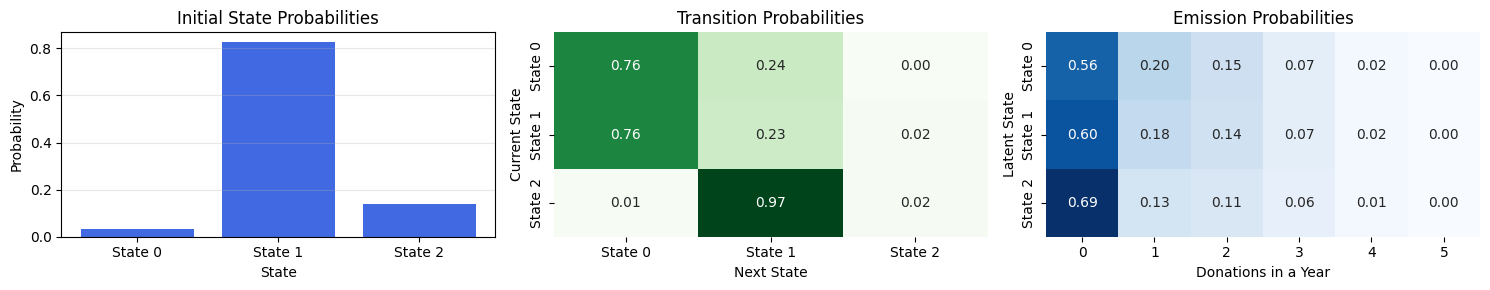

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_hmm_params(transitions, initial_probs, emissions,
                    state_names=None, emission_names=None):
    """
    Plotta in una riga:
    - Matrice di transizione [S, S]
    - Prob iniziali [S]
    - Matrice emissioni [S, K]
    """
    S = len(initial_probs)
    K = emissions.shape[1]
    if state_names is None:
        state_names = [f"State {i}" for i in range(S)]
    if emission_names is None:
        emission_names = [str(i) for i in range(K)]

    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    # Initial probabilities
    axs[0].bar(np.arange(S), initial_probs, color='royalblue')
    axs[0].set_title('Initial State Probabilities')
    axs[0].set_xlabel('State')
    axs[0].set_ylabel('Probability')
    axs[0].set_xticks(np.arange(S))
    axs[0].set_xticklabels(state_names)
    axs[0].grid(axis='y', alpha=0.3)

    # Transition matrix
    sns.heatmap(transitions, annot=True, fmt=".2f", cmap='Greens',
                xticklabels=state_names, yticklabels=state_names, ax=axs[1], cbar=False)
    axs[1].set_title('Transition Probabilities')
    axs[1].set_xlabel('Next State')
    axs[1].set_ylabel('Current State')

    # Emission probabilities/matrix
    sns.heatmap(emissions, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=emission_names, yticklabels=state_names, ax=axs[2], cbar=False)
    axs[2].set_title('Emission Probabilities')
    axs[2].set_xlabel('Donations in a Year')
    axs[2].set_ylabel('Latent State')

    plt.tight_layout()
    plt.show()

# Plot the learned parameters
plot_hmm_params(
    transitions=trans_probs,
    initial_probs=init_probs,
    emissions=emission_probs)

## Full Pyro

### Poisson

In this section, unlike the previous approach, we explicitly define prior distributions for the HMM parameters (initial state, transition matrix, emission rates) using pyro.sample. The guide function introduces variational distributions (with learnable parameters) for these latent variables, enabling fully Bayesian inference via SVI. This allows us to incorporate prior knowledge and quantify uncertainty over the model parameters.

In [ ]:
def model(observations):
    N, T = observations.shape
    num_states = 3

    # If I want to use specific priors, I can define them here
    # rates_prior_shape = torch.tensor([8.0, 5.0, 1.5])
    # rates_prior_rate  = torch.ones(num_states)
    # pi_prior = torch.tensor([10.0, 5.0, 1.0])
    # pi = pyro.sample("pi", dist.Dirichlet(pi_prior))
    # A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    # rates = pyro.sample("rates",dist.Gamma(rates_prior_shape, rates_prior_rate).to_event(1))

    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    rates = pyro.sample("rates", dist.Gamma(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))

    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"ND_{t}", dist.Poisson(rates[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    rates_alpha = pyro.param("rates_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    rates_beta = pyro.param("rates_beta", torch.ones(num_states), constraint=dist.constraints.positive)
    
    # pi_alpha = pyro.param("pi_alpha", torch.tensor([2.0, 1.0, 0.5]), constraint=dist.constraints.positive)
    # rates_alpha = pyro.param("rates_alpha", torch.tensor([4.0, 2.0, 1.0]), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))
    pyro.sample("rates", dist.Gamma(rates_alpha, rates_beta).to_event(1))

pyro.clear_param_store()  # resetta tutti i parametri!

optimizer = Adam({"lr": .01})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)


for step in range(200):
    loss = svi.step(obs_torch)
    if step % 20 == 0:
        print(f"Step {step} loss: {loss}")

Step 0 loss: 130290.28125
Step 20 loss: 130612.921875
Step 40 loss: 130257.546875
Step 60 loss: 130240.34375
Step 80 loss: 130172.7265625
Step 100 loss: 131007.6484375
Step 120 loss: 130342.703125
Step 140 loss: 130595.5234375
Step 160 loss: 130318.34375
Step 180 loss: 130407.9765625


In [69]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("rates_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("rates_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.14374225 0.00239897 0.85385877]
Transition matrix (normalized): [[0.24922238 0.00832487 0.00059674]
 [0.00054702 0.36244825 0.00231347]
 [0.01049764 0.03689923 0.3291504 ]]
Poisson rates: [2.0920506  0.8258707  0.00404216]


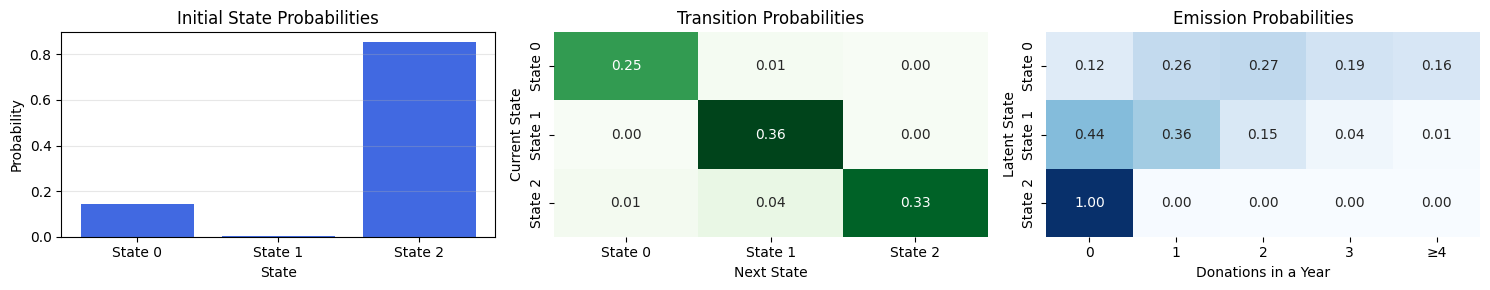

In [70]:
def build_emission_matrix_truncated_poisson(rates, max_k=4):
    S = len(rates)
    K = max_k + 1   # da 0 a max_k incluso
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = poisson.pmf(k, rates[s])
        # L'ultimo raccoglie la coda (tutto >= max_k)
        emissions[s, max_k] = 1 - poisson.cdf(max_k-1, rates[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_poisson(rates_norm, max_k=4)

plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

### Testing

In [79]:
# Dati finti, gli do una prior per fare testing
pi_true = torch.tensor([0.7, 0.2, 0.1])
A_true = torch.tensor([[0.8,0.1,0.1],[0.2,0.7,0.1],[0.3,0.3,0.4]])
rates_true = torch.tensor([1.0, 5.0, 10.0])
T = 2019 - 2009 + 1  # 2010 to 2019 inclusive
states = [torch.multinomial(pi_true, 1).item()]
obs = []
for t in range(T):
    s = states[-1]
    obs.append(torch.poisson(rates_true[s]))
    states.append(torch.multinomial(A_true[s], 1).item())
obs = torch.stack(obs).unsqueeze(0)  # shape [1,T]

def model(observations):
    N, T = observations.shape
    num_states = 3
    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    rates = pyro.sample("rates", dist.Gamma(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))
    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"ND_{t}", dist.Poisson(rates[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    rates_alpha = pyro.param("rates_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    rates_beta = pyro.param("rates_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))  
    pyro.sample("rates", dist.Gamma(rates_alpha, rates_beta).to_event(1))

pyro.clear_param_store()  # resetta tutti i parametri!

optimizer = Adam({"lr": 0.01})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)

for step in range(200):
    loss = svi.step(obs_torch)
    if step % 20 == 0:
        print(f"Step {step}, loss: {loss}")

Step 0, loss: 179962.109375
Step 20, loss: 166164.046875
Step 40, loss: 213955.53125
Step 60, loss: 169925.953125
Step 80, loss: 167065.53125
Step 100, loss: 165692.234375
Step 120, loss: 185993.296875
Step 140, loss: 159002.75
Step 160, loss: 159709.78125
Step 180, loss: 200657.8125


In [44]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("rates_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("rates_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.1463148  0.00658252 0.8471027 ]
Transition matrix (normalized): [[0.2277089  0.00741335 0.00041058]
 [0.0008588  0.36494127 0.00297068]
 [0.01263064 0.03928338 0.34378234]]
Poisson rates: [2.1145298  0.9046744  0.00296376]


Normalize the values

In [45]:
pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", learned_rates_alpha / learned_rates_beta)

Initial state probabilities (normalized): [0.1463148  0.00658252 0.8471027 ]
Transition matrix (normalized): [[0.2277089  0.00741335 0.00041058]
 [0.0008588  0.36494127 0.00297068]
 [0.01263064 0.03928338 0.34378234]]
Poisson rates: [2.1145298  0.9046744  0.00296376]


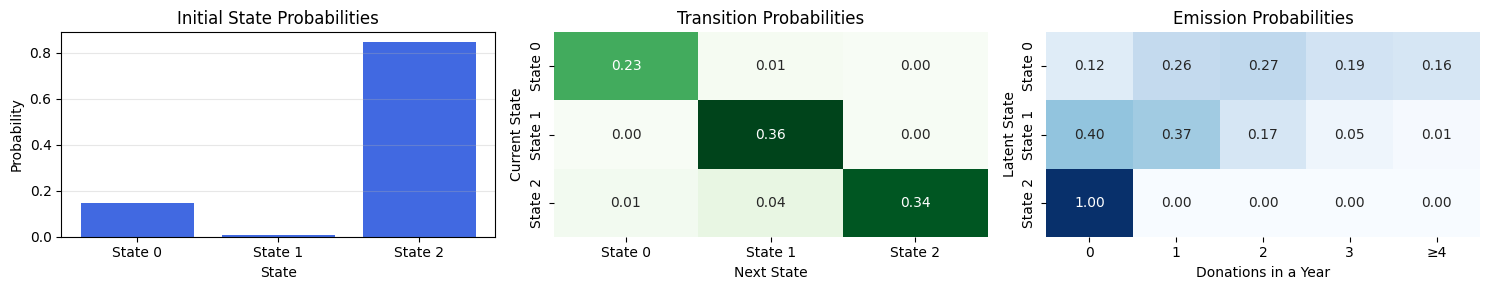

In [48]:
plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=build_emission_matrix_truncated_poisson(rates_norm, max_k=4),
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

### Geometric

In this section, we use a Geometric distribution for the emission probabilities instead of a Poisson. Both distributions can model count data, but with different interpretations: the Poisson models the total number of events in a fixed period, while the Geometric models the number of trials until the first success.
However, in our dataset, the observed data are yearly donation counts ranging from 0 to 4. Using a Geometric emission can provide a different latent structure compared to the Poisson, but it is less natural for bounded count data, since the Geometric is unbounded above. This choice mainly affects how the HMM explains the observed counts and the interpretation of the latent states.

In [74]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam

def model(observations):
    N, T = observations.shape
    num_states = 3

    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    probs = pyro.sample("probs", dist.Beta(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))

    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"y_{t}", dist.Geometric(probs[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    probs_alpha = pyro.param("probs_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    probs_beta = pyro.param("probs_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))
    pyro.sample("probs", dist.Beta(probs_alpha, probs_beta).to_event(1))

pyro.clear_param_store()  # resetta tutti i parametri!

optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1))

# pyro.render_model(model, model_args=(obs_torch,), render_distributions=False)


for step in range(200):
    loss = svi.step(obs_torch)
    if step % 20 == 0:
        print(f"Step {step} loss: {loss}")

Step 0 loss: 184404.6875
Step 20 loss: 188931.78125
Step 40 loss: 179021.328125
Step 60 loss: 184370.75
Step 80 loss: 173592.125
Step 100 loss: 182879.21875
Step 120 loss: 169128.953125
Step 140 loss: 165297.546875
Step 160 loss: 178771.015625
Step 180 loss: 176695.28125


In [77]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("probs_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("probs_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Initial state probabilities (normalized): [0.43575013 0.34304374 0.22120614]
Transition matrix (normalized): [[0.2087608  0.05874154 0.05311325]
 [0.0592472  0.22135285 0.05607066]
 [0.05352712 0.05718495 0.23200162]]
Poisson rates: [1.5890595 1.4649932 1.2233624]


Most people start in state 2, which is expected since some individuals begin donating later or were not eligible to donate due to their age. The transition matrix shows that individuals in state 2 tend to move to state 0 or 1. Once they reach state 0 or 1, donors tend to maintain their donation behavior. State 1 appears to be the most populated, likely representing occasional donors, while state 0 can be interpreted as the state of frequent donors.

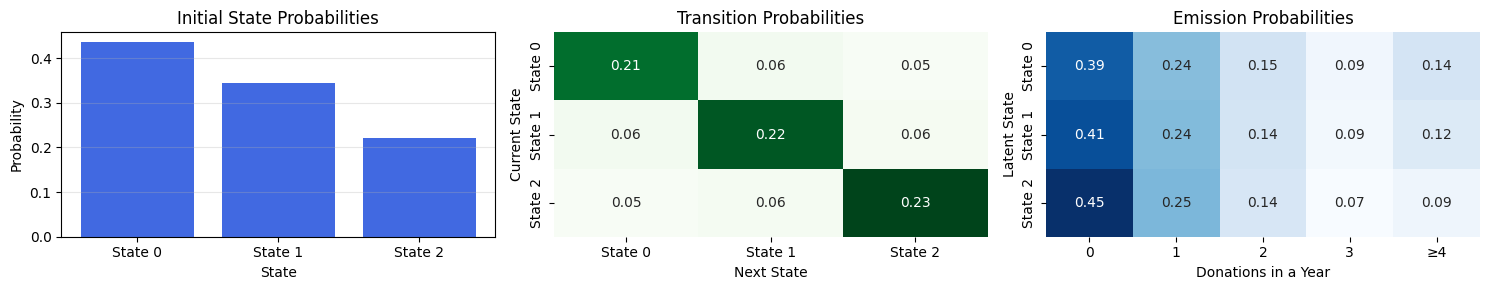

In [78]:
import numpy as np
from scipy.stats import geom

def build_emission_matrix_truncated_geometric(rates, max_k=4):
    S = len(rates)
    K = max_k + 1  # da 0 a 4, 5 valori
    ps = 1 / (rates + 1)
    emissions = np.zeros((S, K))
    for s in range(S):
        # Geometric shiftata: geom.pmf(k+1, p)
        for k in range(max_k):
            emissions[s, k] = geom.pmf(k+1, ps[s])
        # L'ultimo raccoglie tutta la coda: P(y >= max_k)
        emissions[s, max_k] = 1 - geom.cdf(max_k, ps[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_geometric(rates_norm, max_k=4)

plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

## HMM with covariates